In [78]:
import scanpy
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import scprep

In [79]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')
adata_beta_wt = adata_beta[adata_beta.obs['samples'] == 'WT']

In [80]:
colors = list(sns.color_palette('Set1', n_colors=4)) + \
list(sns.color_palette('Paired', n_colors=3)) + ['lightgray'] + \
list(sns.color_palette('Set2', n_colors=7).as_hex())

at_cmap = dict(zip(adata_beta.obs['AT_committment'].cat.categories, colors))
at_order = ['WT AT 1', 'WT AT 2', 'WT AT 3', 'WT AT 4', 'WT AT 5', 'WT AT 6', 'WT AT 7',
            'HFD AT 1', 'HFD AT 2', 'HFD AT 3', 'HFD AT 4', 'OB/OB AT 1', 'OB/OB AT 2', 'OB/OB AT 3', 'Uncommitted']
at_cmap = dict(zip(at_order, [at_cmap[key] for key in at_order]))
colors = [at_cmap['OB/OB AT 2'], at_cmap['WT AT 4']]
cm = LinearSegmentedColormap.from_list( "Custom", colors, N=100)

In [81]:
backwards_trajectories_to_obob2 = np.load('results/islet_run_combined_magic_pca_5_tp_run1_growth/backward_trajectories_OBOB_AT2.npy')
nearest_cells = get_cells_of_origin(backwards_trajectories_to_obob2, adata_beta_wt.obsm['combined_magic_pc_norm'])
backwards_trajectories_wt4_to_obob2 = backwards_trajectories_to_obob2[:, adata_beta_wt[nearest_cells].obs['AT_committment'] == 'WT AT 4', :]

## Visualize WT4 to OBOB2

In [6]:
num_points = backwards_trajectories_wt4_to_obob2.shape[1]

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


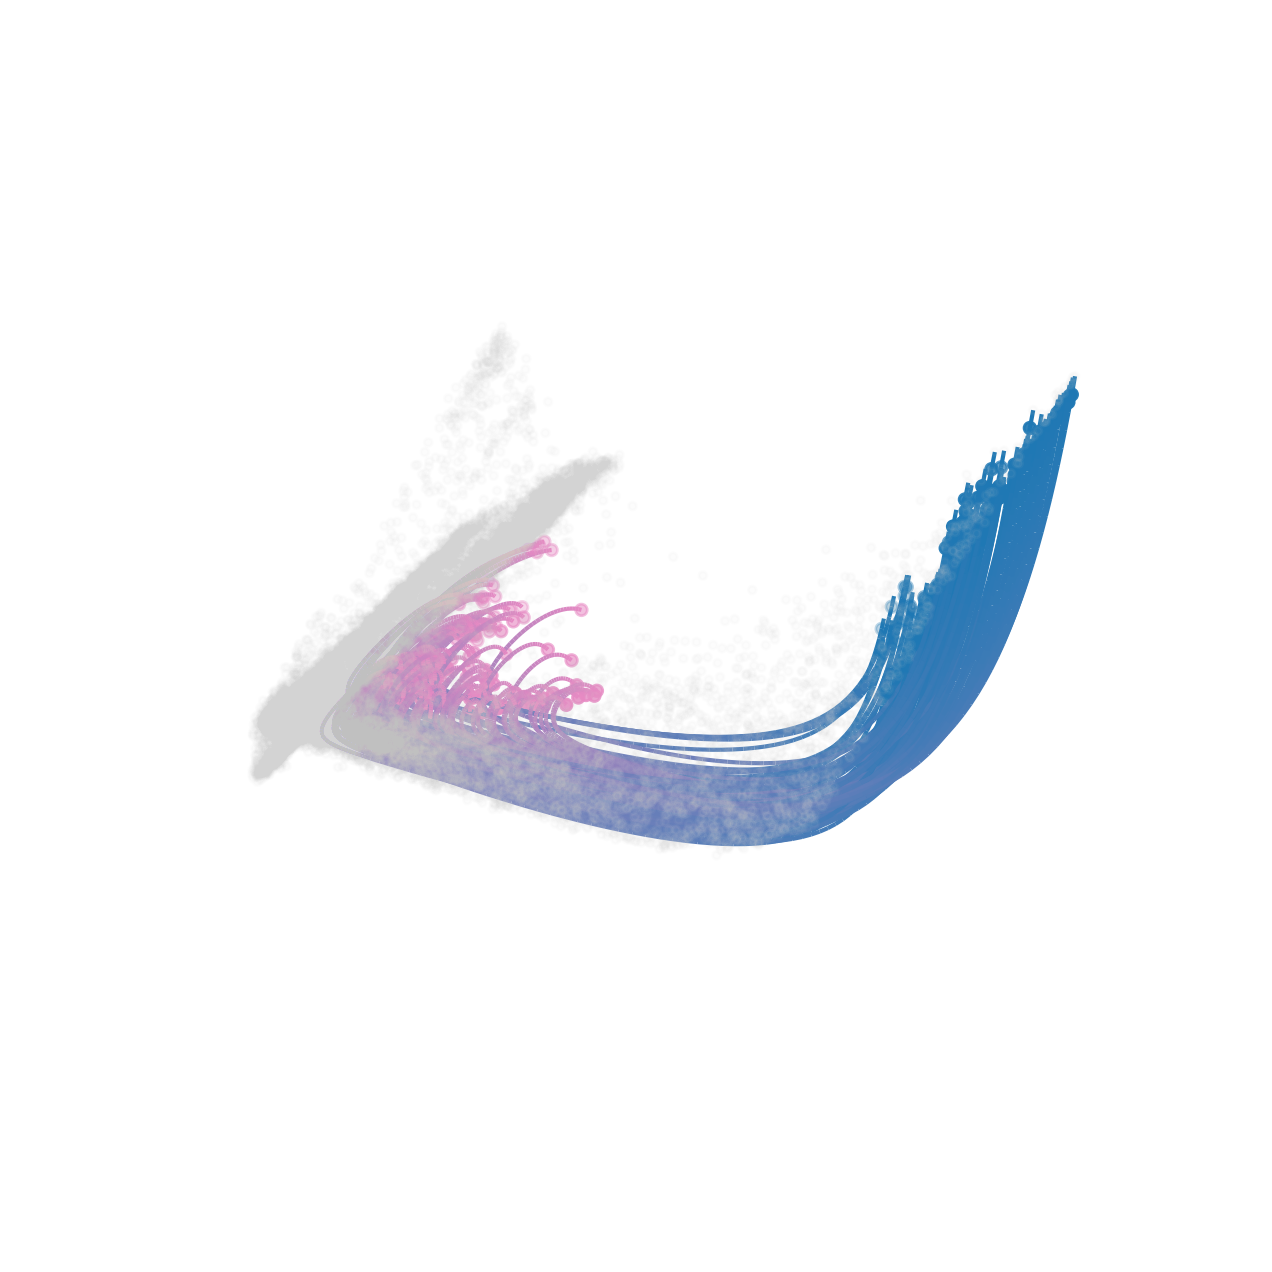

In [7]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

for i in range(num_points):
    x = backwards_trajectories_wt4_to_obob2[:, i, 0]
    y = backwards_trajectories_wt4_to_obob2[:, i, 1]
    z= backwards_trajectories_wt4_to_obob2[:, i, 2]
    t = np.linspace(0,1,100)
    
    points = np.array([x,y,z]).transpose().reshape(-1,1,3)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = Line3DCollection(segs, cmap=cm)
    lc.set_array(t) # color the segments by our parameter
    
    ax.add_collection3d(lc)

scprep.plot.scatter3d(adata_beta.obsm['combined_magic_pc_norm'], c='lightgray', alpha=0.05, ax=ax, s=8)
scprep.plot.scatter3d(backwards_trajectories_wt4_to_obob2[1], c=at_cmap['OB/OB AT 2'], ax=ax, zorder=20)
scprep.plot.scatter3d(backwards_trajectories_wt4_to_obob2[-1], c=at_cmap['WT AT 4'], ax=ax, zorder=20)

ax.axis('off')
fig.savefig(f'figures/WT4_to_OBOB2_trajectory.png', dpi=500)

## AT committment along trajectory for two runs

In [82]:
expected = adata_beta.obs['AT_committment'].value_counts() / adata_beta.n_obs

In [83]:
nearest_cells_at_counts = {}
for time in list(range(100))[::-1]:
    # for cells where first timepoint is WT4, get nearest cells in data
    nearest_cells = get_cells_of_origin(backwards_trajectories_wt4_to_obob2, adata_beta.obsm['combined_magic_pc_norm'], timepoint=time)
    nearest_cells_at_counts[time] = adata_beta[nearest_cells].obs['AT_committment'].value_counts()

In [84]:
df= pd.DataFrame(nearest_cells_at_counts)
df.columns = range(100)

for at in set(at_order) - set(df.index):
    df.loc[at] = 0
df.fillna(0, inplace=True)
df = (df / df.sum(axis=0))
df = (df.T / expected).T
df1 = df.loc[at_order]

In [91]:
# run 2
backwards_trajectories_to_obob2 = np.load('results/islet_run_combined_magic_pca_5_tp_run2_growth/backward_trajectories_OBOB_AT2.npy')
nearest_cells = get_cells_of_origin(backwards_trajectories_to_obob2, adata_beta_wt.obsm['combined_magic_pc_norm'])
backwards_trajectories_wt4_to_obob2 = backwards_trajectories_to_obob2[:, adata_beta_wt[nearest_cells].obs['AT_committment'] == 'WT AT 4', :]

In [92]:
nearest_cells_at_counts = {}
for time in list(range(100))[::-1]:
    # for cells where first timepoint is WT4, get nearest cells in data
    nearest_cells = get_cells_of_origin(backwards_trajectories_wt4_to_obob2, adata_beta.obsm['combined_magic_pc_norm'], timepoint=time)
    nearest_cells_at_counts[time] = adata_beta[nearest_cells].obs['AT_committment'].value_counts()

In [93]:
df= pd.DataFrame(nearest_cells_at_counts)
df.columns = range(100)

for at in set(at_order) - set(df.index):
    df.loc[at] = 0
df.fillna(0, inplace=True)
df = (df / df.sum(axis=0))
df = (df.T / expected).T
df2 = df.loc[at_order]

In [110]:
# combined 2 runs
df = pd.concat((df1, df2), axis=1).T.reset_index(names=['timepoint'])

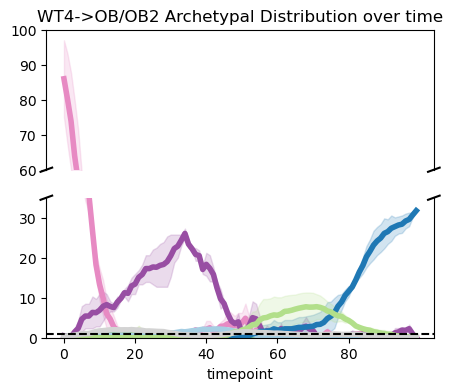

In [120]:
f, (ax, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
ax.set_title('WT4->OB/OB2 Archetypal Distribution over time', color='black')

for i,id in enumerate(at_order):
    sns.lineplot(data=df, x='timepoint', y=id, color=at_cmap[id], linewidth=4, ax=ax)
    sns.lineplot(data=df, x='timepoint', y=id, color=at_cmap[id], linewidth=4, ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(60, 100)  # outliers only
ax2.set_ylim(0, 35)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(None)
ax2.spines['top'].set_visible(None)
ax.set_ylabel(None)
ax2.set_ylabel(None)
ax.tick_params(labeltop=None, bottom=False)  # don't put tick labels at the top

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

f.gca().set_xticks(range(0,100, 20), range(0,100, 20))
plt.axhline(y=1, linestyle='--', color='black')
plt.setp( ax.get_xticklabels(), visible=False)

f.savefig('figures/WT4_OBOB2_archetypal_distribution_ratio_over_time_growth.png', dpi=200)